## Verification

This process will expore the nc file, and it will try to veirify or compare results with the Ulf sites

In [50]:
import pandas as pd
from datetime import datetime
from susi_2022.susi.figures import *
from netCDF4 import Dataset
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt

import matplotlib.pyplot as plt
from scipy.stats import linregress

def mk(path):
    if not os.path.exists(path): os.mkdir(path)
    return path


In [51]:
os.getcwd()

'\\\\nas1.seksko.slu.se\\Extension_100TB\\agandara\\projects\\forestProductivity\\git\\susi-swe'

In [52]:
# general parameters

working_folder = 'outputs'  #where the nc data is located
#outpara = working_folder
files = glob(working_folder+'/*.nc')  # it will read all the nc files in folder
tfiles = pd.DataFrame({'files': files})


pFile = pd.read_excel("inputs\sweden\parameters.xlsx")  #calls the parameter file used to run susi, to collect initial date and site names
sites = pFile.columns[9:]

tsites = pd.DataFrame({'sites':sites})
tfiles.join(tsites)

gwl_observations = f'O:/projects/forestProductivity/01_data_acquisition/Ulf/SecondData/GVN_Man_ALL tidy by Alejandro Gandara.csv'


In [53]:
tfiles.join(tsites)

,files,sites
0,outputs\01_Bjdamm_susi.nc,01_Bjdamm
1,outputs\03_Korpis_susi.nc,03_Korpis
2,outputs\04_Frojered_susi.nc,04_Fröjered
3,outputs\05_StraRed_susi.nc,05_SträRed
4,outputs\06_Risabo_susi.nc,06_Risabo
5,outputs\07_Rothult_susi.nc,07_Rothult
6,outputs\08_Ydreham_susi.nc,08_Ydreham
7,outputs\09_Grongol_susi.nc,09_Gröngöl
8,outputs\10_Hallehult_susi.nc,10_Hällehult
9,outputs\11_okalix_susi.nc,11_Ökalix


In [54]:
scen = 0
ind = 12

#Graphs
facecolor='#f2f5eb'
fs = 15



# hide

In [55]:

# Calculated variables

wsite = sites[ind]
print(f'site: {wsite}')

#output folder
output_folder = mk(f'{working_folder}/graphs/{wsite}/')


#pFile[wsite]
start_date = pFile.loc[pFile['key']=='start_date', [wsite] ].values[0]
end_date = pFile.loc[pFile['key']=='end_date', [wsite] ].values[0]
days = end_date - start_date
years = end_date[0].year - start_date[0].year
print(f"{years} years, and {days[0].days} days, from: {start_date[0].strftime('%Y-%m-%d')} to: {end_date[0].strftime('%Y-%m-%d')}")

start_date = start_date[0].strftime('%Y-%m-%d')
end_date = end_date[0].strftime('%Y-%m-%d')
ff = files[ind]
#ncf = Dataset('outputs\\05_StraRed_susi.nc', mode='r')
ncf = Dataset(ff, mode='r')

site: 14_Höglund
27 years, and 10226 days, from: 1993-01-01 to: 2020-12-31


In [56]:
#print(files[ind])
#ncf['strip']['dwtyr'][0,13]
#print(ncf)
#ncf['strip']['dwt'][scen,:, :]

In [57]:
# Graphs
#hydrology(ff, scen)
#stand(ff, scen)
#mass(ff, scen)
#carbon(ff, scen)
##compare_1(ff, [0,1])


In [58]:
# Ulf water table data in the obs_GWL
# filter for site and calculate the relative day using the .nc file for reference

obs_GWL = pd.read_csv(gwl_observations, encoding='latin1', sep=';')
obs_GWL = obs_GWL.loc[(obs_GWL.Transekt == 'mean') & (obs_GWL.site == wsite)][['site','date', 'wt']]
obs_GWL['date'] =  pd.to_datetime(obs_GWL['date'])
obs_GWL['relative_day'] = obs_GWL['date'].apply(lambda x: (x - np.datetime64(start_date)).days)
obs_GWL.set_index('relative_day', drop=False, inplace=True)



# obs_GWL.set_index('date', drop=False, inplace=True)
# obs_GWL_t = obs_GWL.reindex(pd.date_range(start_date[0].strftime('%Y-%m-%d'), end_date[0].strftime('%Y-%m-%d')).format("YYY%-mm%-dd%"), fill_value=None).iloc[1:]
# obs_GWL = obs_GWL_t.combine_first(obs_GWL)
# obs_GWL.date = obs_GWL.index
# obs_GWL = obs_GWL[obs_GWL.date.notnull()]



# print(len(obs_GWL))
#obs_GWL[pd.notnull(obs_GWL['wt'])]

In [59]:
# basal area
ba_mean = np.mean(ncf['stand']['basalarea'][scen,:, :], axis=1)
bai = np.diff(ba_mean, axis=0,  prepend=0)

#working_folder + '/graphs/' + wsite +
BasalArea = pd.DataFrame({
    'year': pd.date_range(start_date, end_date, freq="Y").strftime('%Y'),
    'ba':ba_mean[1:].tolist(),
    'bai':bai[1:].tolist()
})
BasalArea.to_csv(output_folder +  wsite + '_Basal Area.csv')

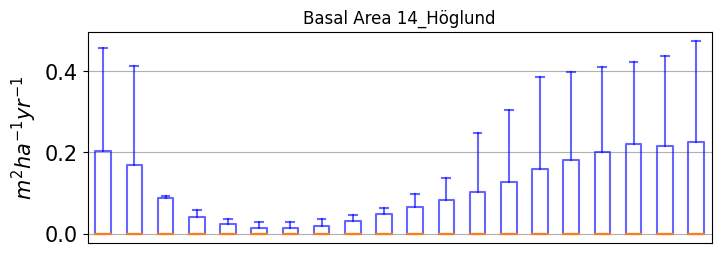

In [60]:
#facecolor = '#f2f5eb'
#fs = 12
cols =ncf.dimensions['ncols'].size #20
fig = plt.figure(num='stand', figsize=(25,18))   #width, height
gs = gridspec.GridSpec(ncols=12, nrows=12, figure=fig, wspace=0.25, hspace=0.25)

ba = ncf['stand']['basalarea'][scen,:, :]
growth = np.diff(ba, axis=0)
dfgrowth = pd.DataFrame(data=growth, columns=list(range(cols)))
axgrowth = fig.add_subplot(gs[8:10, :4])
dfgrowth.boxplot(ax = axgrowth,
                color=dict(boxes='blue', whiskers='blue', medians='blue', caps='blue'),
                boxprops=dict(linestyle='-', linewidth=1.5, color='blue', alpha=0.6),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5, color='blue', alpha=0.6),
                capprops=dict(linestyle='-', linewidth=1.5, color='blue', alpha=0.6),
                showfliers=False, grid=True, rot=2)

axgrowth.set_title('Basal Area ' + wsite)
axgrowth.set_ylabel('$m^2 ha^{-1} yr^{-1}$', fontsize=fs)

axgrowth.get_xaxis().set_visible(False)
axgrowth.tick_params(axis='y', labelsize=fs)
#axgrowth.set_facecolor(facecolor)
plt.savefig(output_folder + wsite + '_Basal Area.png', bbox_inches='tight')

In [61]:
len(np.mean(ncf['stand']['basalarea'][scen,:, :], axis=1))
print(len(ncf['stand']['basalarea'][scen,:, :]))


29


In [62]:
y = pd.date_range(start_date, end_date, freq="Y").strftime('%Y')
print(y)
print(f'{len(y)} years')

Index(['1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020'],
      dtype='object')
28 years


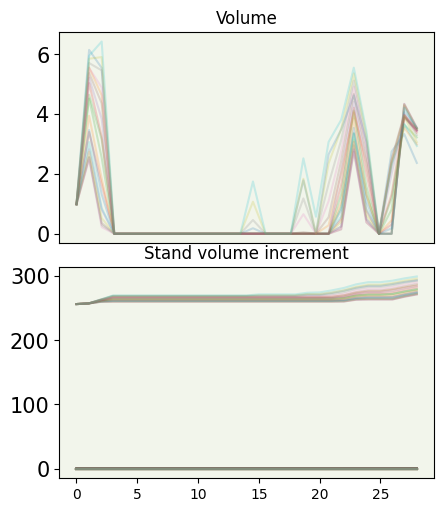

In [63]:
fig = plt.figure(num='stand', figsize=(15,18))   #width, height
gs = gridspec.GridSpec(ncols=12, nrows=12, figure=fig, wspace=0.25, hspace=0.25)

vol = ncf['stand']['volume'][scen,:, :]
    
ax = fig.add_subplot(gs[10:, 8:])
totvol = vol[:,:]
domvol = ncf['stand']['dominant']['volume'][scen,:, :]
subdomvol = ncf['stand']['subdominant']['volume'][scen,:, :]
undervol= ncf['stand']['under']['volume'][scen,:, :]
for c in range(cols):
    ax.plot(totvol[:,c], alpha=0.2)
for c in range(cols):
    ax.plot(domvol[:,c], alpha=0.2)
for c in range(cols):
    ax.plot(subdomvol[:,c], alpha=0.2)
for c in range(cols):
    ax.plot(undervol[:,c], alpha=0.2)
    
ax.set_facecolor(facecolor)
ax.tick_params(axis='y', labelsize=fs)
ax.set_title('Stand volume increment')

ax = fig.add_subplot(gs[8:10, 8:])
vol = ncf['stand']['volume'][scen,:, :]
for c in range(cols):
    ax.plot(np.diff(vol[:,c]), alpha=0.2)
    
ax.set_facecolor(facecolor)
ax.tick_params(axis='y', labelsize=fs)
ax.set_title('Volume')
ax.get_xaxis().set_visible(False) 


#fig.savefig('myplot.jpg', dpi=300, bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


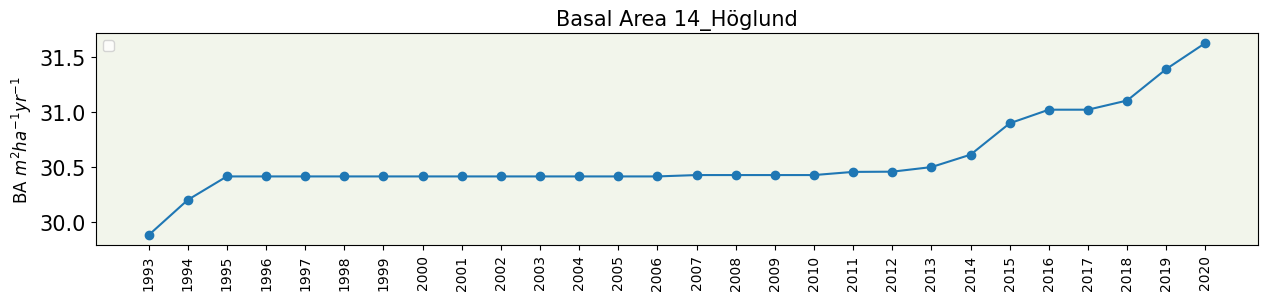

In [64]:
# Basal area
baFig = plt.figure(num='BasalArea', figsize=(15,18))
gs = gridspec.GridSpec(ncols=12, nrows=12, figure=baFig, wspace=0.25, hspace=0.25)

axwtts = baFig.add_subplot(gs[8:10, :])
axwtts.scatter(x= BasalArea['year'], y=BasalArea['ba'])
axwtts.plot(BasalArea['ba'])
axwtts.set_title('Basal Area ' + wsite, fontsize=fs)
axwtts.tick_params(axis='y', labelsize=fs)
axwtts.set_ylabel('BA $m^2 ha^{-1} yr^{-1}$', fontsize=fs*0.8)
axwtts.legend(loc= 'upper left')
axwtts.grid(visible=False)
axwtts.set_facecolor(facecolor)
plt.xticks(rotation=90)
plt.savefig(output_folder +  wsite + '_ba.png', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


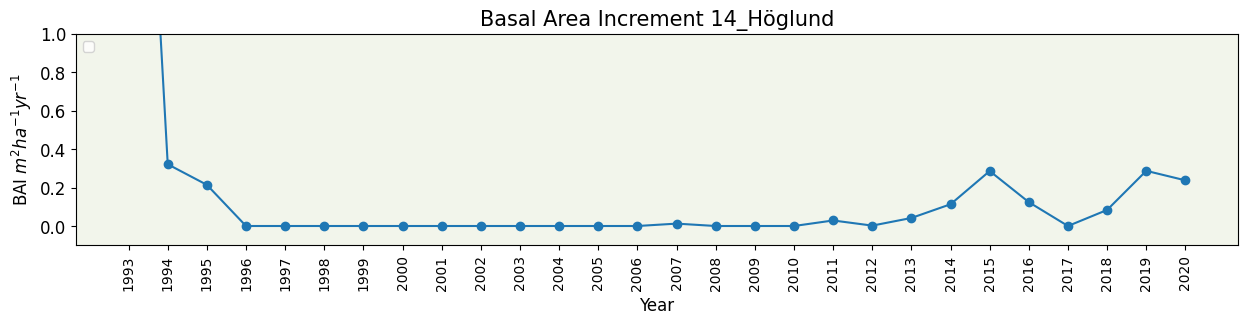

In [65]:
#Basal Area increment
baiFig = plt.figure(num='BasalArea', figsize=(15,18))
gs = gridspec.GridSpec(ncols=12, nrows=12, figure=baiFig, wspace=0.25, hspace=0.25)
axwtts = baiFig.add_subplot(gs[8:10, :])
axwtts.scatter(x= BasalArea['year'], y=BasalArea['bai'])
axwtts.plot(BasalArea['bai'],  )

axwtts.set_title('Basal Area Increment ' + wsite, fontsize=fs)
axwtts.tick_params(axis='y', labelsize=fs*0.8)
axwtts.set_ylabel('BAI $m^2 ha^{-1} yr^{-1}$', fontsize=fs*0.8)
axwtts.set_xlabel('Year', fontsize=fs*0.8)

axwtts.legend(loc= 'upper left')
axwtts.grid(visible=False)
axwtts.set_ylim([-0.1,1])
axwtts.set_facecolor(facecolor)
plt.xticks(rotation=90)

plt.savefig(output_folder +  wsite + '_bai.png', bbox_inches='tight')

In [66]:
obs_GWL[obs_GWL['wt'].notna()]

,site,date,wt,relative_day
relative_day,,,,
8570,14_Höglund,2016-06-19,-0.547222222,8570
8585,14_Höglund,2016-07-04,-0.171111111,8585
8599,14_Höglund,2016-07-18,-0.266666667,8599
8613,14_Höglund,2016-08-01,-0.418333333,8613
8627,14_Höglund,2016-08-15,-0.277222222,8627
8641,14_Höglund,2016-08-29,-0.266666667,8641
8655,14_Höglund,2016-09-12,-0.571111111,8655
8669,14_Höglund,2016-09-26,-0.716666667,8669
8682,14_Höglund,2016-10-09,-0.577222222,8682


In [67]:
#wt = np.mean(ncf['strip']['dwtyr'][scen,1:, :], axis = 1)
#wt = np.mean(ncf['strip']['dwt'][scen,:, :], axis = 1)


In [68]:
len(np.mean(ncf['strip']['dwtyr_latesummer'][scen,:, :], axis = 1))

29

In [69]:
#Get water table
#daily water table
wt = np.mean(ncf['strip']['dwt'][scen,:, :], axis = 1)  

#observed water table
df_wt = pd.DataFrame({'wt':wt})  
df_wt['relative_day'] = df_wt.index

#Observed and modeled water table
wt_comp = df_wt.join(obs_GWL, lsuffix='_est')  
wt_comp['wt'] = pd.to_numeric(wt_comp['wt'], errors='coerce')
wt_comp['date_est'] = pd.to_datetime(start_date) + pd.to_timedelta(wt_comp['relative_day_est'], unit='d')
wt_comp = wt_comp.set_index('date_est')


#    df_wt = pd.DataFrame({'wt':wt})
#    df_wt['relative_day'] = df_wt.index
#    wt_comp = df_wt.join(obs_GWL, lsuffix='_est')
tail = 200
wt_comp_tail= wt_comp.loc[(wt_comp['relative_day_est'] >= (obs_GWL.relative_day.min()-tail)) & (wt_comp['relative_day_est'] <= (obs_GWL.relative_day.max()+tail))]

#    wt_comp['wt'] = pd.to_numeric(wt_comp['wt'], errors='coerce')
#    wt_comp['date_est'] = pd.to_datetime(start_date) + pd.to_timedelta(wt_comp['relative_day_est'], unit='d')
#    wt_comp = wt_comp.set_index('date_est')
    

In [70]:
files

['outputs\\01_Bjdamm_susi.nc',
 'outputs\\03_Korpis_susi.nc',
 'outputs\\04_Frojered_susi.nc',
 'outputs\\05_StraRed_susi.nc',
 'outputs\\06_Risabo_susi.nc',
 'outputs\\07_Rothult_susi.nc',
 'outputs\\08_Ydreham_susi.nc',
 'outputs\\09_Grongol_susi.nc',
 'outputs\\10_Hallehult_susi.nc',
 'outputs\\11_okalix_susi.nc',
 'outputs\\12_okalix_susi.nc',
 'outputs\\13_okalix_susi.nc',
 'outputs\\14_Hoglund_susi.nc',
 'outputs\\15_Jornmark_susi.nc']

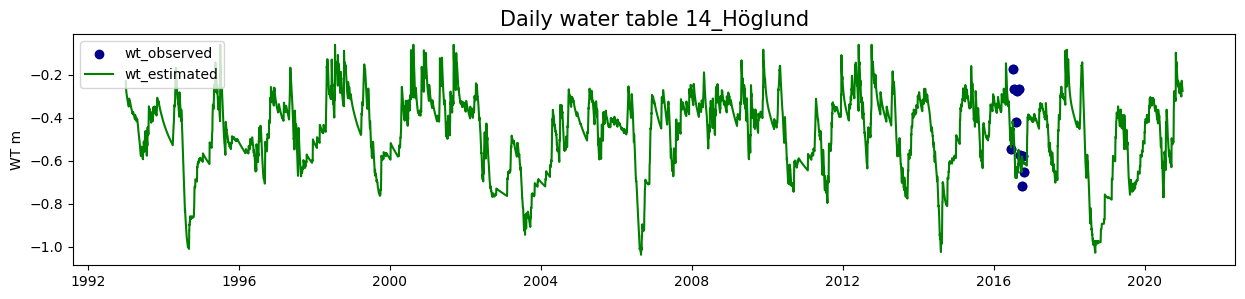

In [71]:
# Daily water table
wt_fig = plt.figure(num='Water table', figsize=(15,3)) 
if len(obs_GWL) > 0: 
    plt.scatter(wt_comp.index, wt_comp['wt'], label='wt_observed', color='darkblue')
plt.plot(wt_comp['wt_est'], label='wt_estimated', color='green')
#plt.xlabel(wt_comp['date_est'])
plt.legend(loc=2)
plt.title('Daily water table ' + wsite, fontsize = 15)
plt.ylabel('WT m')
plt.savefig(output_folder +  wsite + '_wt.png', bbox_inches='tight')

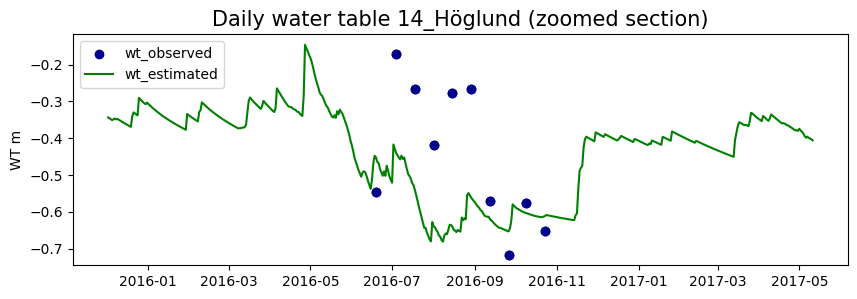

In [72]:
if len(obs_GWL) > 0:
    wt_fig_section = plt.figure(num='Water table', figsize=(10,3)) 
    if len(obs_GWL) > 0: 
        plt.scatter(wt_comp_tail.index, wt_comp_tail['wt'], label='wt_observed', color='darkblue')
    plt.plot(wt_comp_tail['wt_est'], label='wt_estimated', color='green')
    #plt.xlabel(wt_comp['date_est'])
    plt.legend(loc=2)
    plt.title('Daily water table ' + wsite + ' (zoomed section)', fontsize = 15)
    plt.ylabel('WT m')
    plt.savefig(output_folder +  wsite + '_wt_section.png', bbox_inches='tight')

# unhide

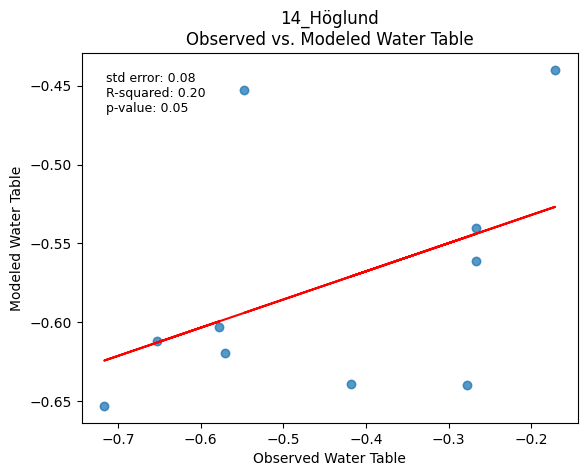

In [73]:

# read data from a CSV file
data = wt_comp.dropna(subset=['wt'])

# calculate linear regression line
slope, intercept, r_value, p_value, std_err = linregress(data['wt'], data['wt_est'])
line = slope * data['wt'] + intercept

xyfig = plt.figure(num='xy comp') 
# plot observed vs. modeled water table with linear regression line
plt.scatter(data['wt'], data['wt_est'], alpha=0.5)
plt.plot(data['wt'], line, color='red')
plt.xlabel('Observed Water Table')
plt.ylabel('Modeled Water Table')
plt.title(wsite + '\nObserved vs. Modeled Water Table')

# calculate and print R-squared value as a measure of model fit
r_squared = r_value ** 2
#stats_text = f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {r_squared:.2f}\np-value: {p_value:.2f}'
stats_text = f'std error: {std_err:.2f}\nR-squared: {r_squared:.2f}\np-value: {p_value:.2f}'

plt.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=9, ha='left', va='top')

# show plot and save
plt.show()
xyfig.savefig(output_folder +  wsite + '_wt_observed vs modeled.png', bbox_inches='tight')

data.to_csv(output_folder +  wsite + '_wt_observed_modeled.csv', sep=';')

#  
lm_restult = pd.DataFrame({'site':wsite, 'rvalue': r_value, 'r_squared' : r_squared,'pvalue': p_value,
                   'stderr':std_err}, index=[0])
lm_restult.to_csv(output_folder +  wsite + '_wt_lm.csv', sep=';')


In [74]:
ncf.close()